# Lib import

In [380]:
# 기본 데이터 처리 라이브러리
import os
import sys
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
from tqdm import tqdm

# 지리 정보 처리 관련 라이브러리
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box

# 머신러닝 관련 라이브러리
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# DuckDB 데이터베이스 연결
import duckdb

# UDM

In [38]:
def mk_pnt(x):
    return Point(x['X좌표'], x['Y좌표'])

def make_geodf(target_df):
    '''
    TAAS Data is EPSG : 4326 (lat, long)
    so transform to GeoDataFrame's crs = 4326
    '''
    target_df['geometry'] = target_df.apply(lambda x : mk_pnt(x), axis=1)
    target_df = gpd.GeoDataFrame(target_df, geometry='geometry', crs='EPSG:4326')
    return target_df

# TEST
- 가분석을 위한 테스트 공간

## Data Load & Extract

### GRID

In [2]:
full_grid = gpd.read_file('../GIS/result/Korea_Grid_200m_5179.shp')

In [3]:
gn_grid = full_grid[full_grid['SIG_KOR_NM'] == '강남구']

In [4]:
gn_grid.reset_index(drop=True, inplace=True)

### TAAS
- 강남구

In [235]:
df = pd.read_csv('../../KoRoad/TAAS/교통사고DATA_2018_2023.csv',encoding='cp949', low_memory=False)

In [148]:
gn_acc = df[df['발생시군구'] == '강남구']
gn_acc['사고내용'] = pd.Categorical(gn_acc['사고내용'], categories=['부상신고','경상','중상','사망'], ordered=True)
gn_acc_gdf = make_geodf(gn_acc)

gn_acc_gdf.to_crs(epsg=5179,inplace=True)

/tmp/ipykernel_350124/843991857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gn_acc['사고내용'] = pd.Categorical(gn_acc['사고내용'], categories=['부상신고','경상','중상','사망'], ordered=True)
/tmp/ipykernel_350124/2985772811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['geometry'] = target_df.apply(lambda x : mk_pnt(x), axis=1)


### 사고에 GRID GID 입히기

In [149]:
intersect_list = gpd.sjoin(gn_acc_gdf, gn_grid[['geometry','gid']], how='left', predicate='within')

In [165]:
intersect_list.iloc[:,-5:].head()

,고령운전자사고여부,중상이상사고여부,geometry,index_right,gid
64,아니오,예,POINT (959928 1943154),347.0,14805.0
311,아니오,아니오,POINT (958060 1944849),NaN,NaN
368,아니오,아니오,POINT (959602 1946385),296.0,14754.0
371,아니오,예,POINT (960302 1944648),391.0,14849.0
491,아니오,아니오,POINT (961293 1945849),577.0,15035.0


### 월별 Grid 만들기

In [159]:
rows = []
for _, row in gn_grid.iterrows():
    for month in range(1, 13):
        # 각 gid와 월을 새로운 행으로 추가
        rows.append({'gid': row['gid'], '월': month, 'geometry': row['geometry']})

# 새로운 데이터프레임으로 변환
gn_month_grid = gpd.GeoDataFrame(rows, geometry='geometry')

## GRID에 사고건수 그려보기

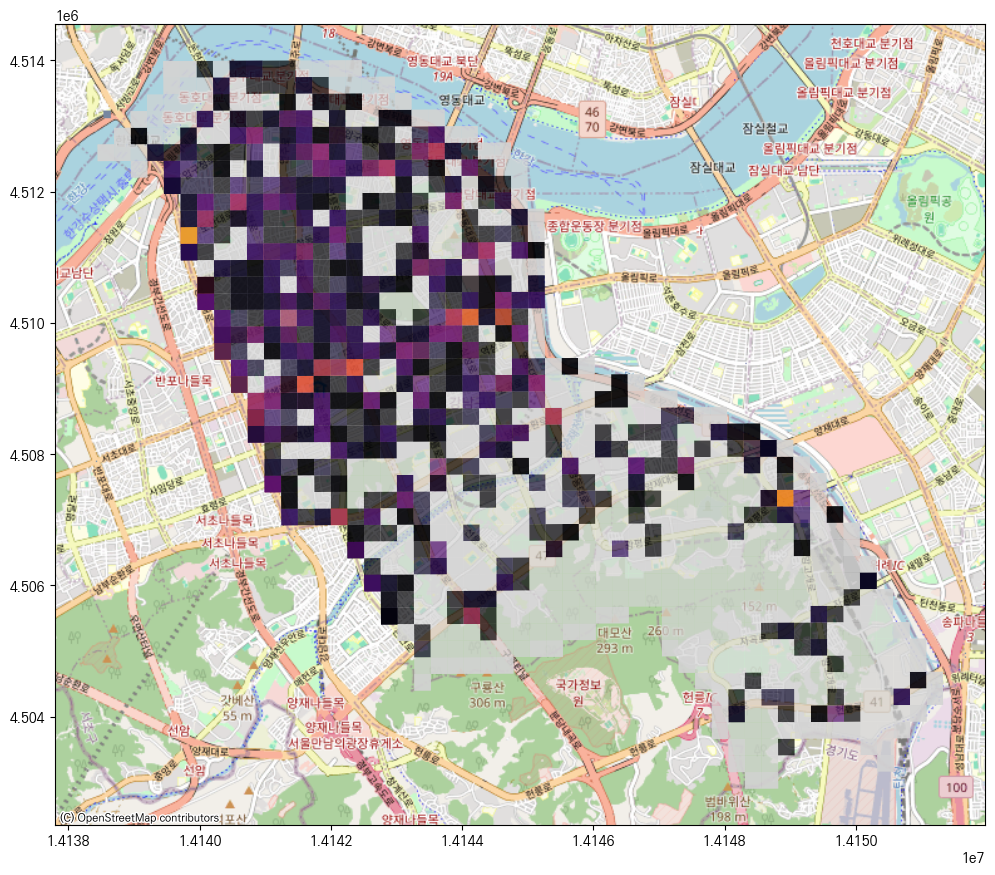

In [156]:
import contextily as ctx
tmp = pd.merge(gn_grid,gb[gb['발생월']==12], left_on='gid', right_on='gid',how='left')
tmp.to_crs(epsg=3857,inplace=True)
ax = tmp.plot(column='TAAS사고번호', missing_kwds = {'color':'lightgray'},figsize=(12,12),cmap='inferno',alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [385]:
full_grid

,SIDO_CD,SIDO_NM,SIG_CD,SIG_KOR_NM,gid,geometry
0,11,서울특별시,11110,종로구,0,"POLYGON ((951510.252 1958154.044, 951310.252 1..."
1,11,서울특별시,11110,종로구,1,"POLYGON ((951510.252 1958154.044, 951310.252 1..."
2,11,서울특별시,11110,종로구,2,"POLYGON ((951510.252 1958354.044, 951310.252 1..."
3,11,서울특별시,11110,종로구,3,"POLYGON ((951510.252 1958354.044, 951310.252 1..."
4,11,서울특별시,11110,종로구,4,"POLYGON ((951710.252 1956554.044, 951510.252 1..."
...,...,...,...,...,...,...
2616890,51,강원특별자치도,51830,양양군,2616890,"POLYGON ((1114910.252 1991754.044, 1114710.252..."
2616891,51,강원특별자치도,51830,양양군,2616891,"POLYGON ((1114910.252 1991954.044, 1114710.252..."
2616892,51,강원특별자치도,51830,양양군,2616892,"POLYGON ((1115110.252 1991554.044, 1114910.252..."
2616893,51,강원특별자치도,51830,양양군,2616893,"POLYGON ((1115110.252 1991554.044, 1114910.252..."


In [390]:
import geopandas as gpd

def create_monthly_grid(gdf, sido_nm=None, sig_kor_nm=None, months=12):
    """
    주어진 GeoDataFrame에서 월별로 grid 데이터를 생성하되, SIDO_NM이나 SIG_KOR_NM으로 필터링할 수 있는 함수.
    
    Args:
    - gdf: 원본 GeoDataFrame (gid, geometry, SIDO_NM, SIG_KOR_NM를 포함해야 함)
    - sido_nm: 선택적으로 필터링할 SIDO_NM 값 (기본값: None)
    - sig_kor_nm: 선택적으로 필터링할 SIG_KOR_NM 값 (기본값: None)
    - months: 월의 개수 (기본값: 12)
    
    Returns:
    - 새로운 GeoDataFrame: 각 gid에 대해 월별로 생성된 데이터프레임

    Examples:
    - 특정 SIDO_NM으로 필터링 (예: 서울특별시): 
        gn_month_grid_sido = create_monthly_grid(full_grid, sido_nm='서울특별시')
    - 특정 SIG_KOR_NM으로 필터링 (예: 종로구) : 
        gn_month_grid_sig = create_monthly_grid(full_grid, sig_kor_nm='종로구')
    - SIDO_NM과 SIG_KOR_NM 둘 다 필터링 (예: 서울특별시, 종로구) : 
        gn_month_grid_both = create_monthly_grid(full_grid, sido_nm='서울특별시', sig_kor_nm='종로구')
    """
    # SIDO_NM 필터링
    if sido_nm:
        gdf = gdf[gdf['SIDO_NM'] == sido_nm]
    
    # SIG_KOR_NM 필터링
    if sig_kor_nm:
        gdf = gdf[gdf['SIG_KOR_NM'] == sig_kor_nm]
    
    # 필터링 후 데이터프레임이 비어있다면 에러 처리
    if gdf.empty:
        raise ValueError("주어진 조건에 맞는 데이터가 없습니다.")
    
    rows = []
    
    # 각 row에 대해 1월부터 n월까지의 데이터를 추가
    for _, row in gdf.iterrows():
        for month in range(1, months + 1):
            rows.append({'gid': row['gid'], '월': month, 'geometry': row['geometry']})
    
    # 새로운 GeoDataFrame으로 변환
    monthly_grid_gdf = gpd.GeoDataFrame(rows, geometry='geometry')
    
    return monthly_grid_gdf

In [ ]:
create_monthly_grid()